In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader

In [2]:
df = pd.read_csv(r"C:\Users\admin\Desktop\week_of_data4_headFlaw.csv",encoding='utf-8',header=None)
df.head()

,0,1,2,3
0,2015/5/20 0:00,263,240,2015/5/20
1,2015/5/20 0:05,263,234,2015/5/20
2,2015/5/20 0:10,263,228,2015/5/20
3,2015/5/20 0:15,263,227,2015/5/20
4,2015/5/20 0:20,263,228,2015/5/20


In [3]:
df.columns = ['time','id','gl', 'date']
df = df[['time','id','gl']]

In [4]:
df.head()

,time,id,gl
0,2015/5/20 0:00,263,240
1,2015/5/20 0:05,263,234
2,2015/5/20 0:10,263,228
3,2015/5/20 0:15,263,227
4,2015/5/20 0:20,263,228


In [5]:
ID = df['id'].value_counts().index
pd.set_option('display.max_rows',100)
print(ID)
print(len(ID))

Index([263, 106, 185, 218,  74,  53, 216, 219, 113,  47,  14, 134,  37,  61,
        46,  33,  54, 278, 136, 274,   9, 265, 283, 273, 119, 129,  32,  27,
       236,  26, 206,  18, 165,  31,  24, 267,  22, 247, 124,  79, 258,  58,
       234, 175, 156, 158, 188, 189, 201, 203,  77, 127,  67,  70, 102, 137,
         7,  95, 232,  23, 271, 130,  68, 227, 228, 164, 111, 251, 155, 245,
       229, 277, 193, 101, 269,   3, 250, 116, 109,  81,  65, 184, 146, 105,
       138,  76, 198, 139, 214, 166, 135, 123, 253, 187,  17, 205, 220, 243,
       281],
      dtype='int64', name='id')
99


In [6]:
#获取数据

# 创建空的DataFrame
total_data = {'id': [],'month':[],'day':[],'hour':[],'minute':[],'weekday':[],'gl': []}
total_data = pd.DataFrame(total_data)

for i in ID:
    print("开始获取id为{}的被试数据：---------------------------------".format(i))
    data = df[df['id']== i].copy() 
    print(data.shape)
    #将time列设成date数据类型
    data['time'] = pd.to_datetime(data['time'])

    #按照时间排序
    data = data.sort_values(by='time') 

    #提取月为单独的一列
    data['month'] = data['time'].dt.month

    #提取日为单独的一列
    data['day'] = data['time'].dt.day

    #提取小时为单独的一列
    data['hour'] = data['time'].dt.hour

    #提取分钟为单独的一列
    data['minute'] = data['time'].dt.minute

    # 提取周几（0表示星期一，1表示星期二，依此类推）
    data['weekday'] = data['time'].dt.dayofweek

    #将Time列设成索引
    data = data.set_index('time')

#     data['target'] = data['gl'].shift(-1)

    #使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
    data = data.dropna()     

    data = data.astype(np.float32) # 修改数据类型
    
    #整合全部数据
    total_data = pd.concat([total_data, data], ignore_index=True)

开始获取id为263的被试数据：---------------------------------
(2016, 3)
开始获取id为106的被试数据：---------------------------------
(2016, 3)
开始获取id为185的被试数据：---------------------------------
(2016, 3)
开始获取id为218的被试数据：---------------------------------
(2016, 3)
开始获取id为74的被试数据：---------------------------------
(2016, 3)
开始获取id为53的被试数据：---------------------------------
(2016, 3)
开始获取id为216的被试数据：---------------------------------
(2016, 3)
开始获取id为219的被试数据：---------------------------------
(2016, 3)
开始获取id为113的被试数据：---------------------------------
(2016, 3)
开始获取id为47的被试数据：---------------------------------
(2016, 3)
开始获取id为14的被试数据：---------------------------------
(2016, 3)
开始获取id为134的被试数据：---------------------------------
(2016, 3)
开始获取id为37的被试数据：---------------------------------
(2016, 3)
开始获取id为61的被试数据：---------------------------------
(2016, 3)
开始获取id为46的被试数据：---------------------------------
(2016, 3)
开始获取id为33的被试数据：---------------------------------
(2016, 3)
开始获取id为54的被试数据：---------------------------------

In [7]:
ID1 = total_data['id'].value_counts().index
pd.set_option('display.max_rows',100)
print(len(ID1))

99


In [8]:
total_data.head()

,id,month,day,hour,minute,weekday,gl
0,263.0,5.0,20.0,0.0,0.0,2.0,240.0
1,263.0,5.0,20.0,0.0,5.0,2.0,234.0
2,263.0,5.0,20.0,0.0,10.0,2.0,228.0
3,263.0,5.0,20.0,0.0,15.0,2.0,227.0
4,263.0,5.0,20.0,0.0,20.0,2.0,228.0


In [9]:
#窗口划分
# 创建一个空的三维数组
train_total_feats = np.empty((0, 24, 7)) 
train_total_targets = np.empty((0,7))

test_total_feats = []
test_total_targets = []

# 设每条数据序列有24组数据
seq = 24
for i in ID1:
    data = total_data[total_data['id'] == i]
    print("当前被试(id == {})的数据集长度：".format(i),data.shape)
    
    # 创建两个列表，用来存储当前被试的数据特征和标签
    data_feat, data_target = [],[]
    for index in range(len(data) - seq):
        # 构建特征集
        data_feat.append(data[['id','month','day','hour','minute','weekday','gl']][index: index + seq].values)
        # 构建target集
        data_target.append(data[['id','month','day','hour','minute','weekday','gl']].iloc[index + seq])
        
    # 将特征集和标签集整理成numpy数组
    data_feat = np.array(data_feat)
    data_target = np.array(data_target)
    
    #划分每个被试的训练集和测试集
    test_size = int(np.round(0.2 * data_feat.shape[0]))  # np.round(1)是四舍五入
    train_size = data_feat.shape[0] - test_size 
    
    train_total_feats = np.concatenate((train_total_feats, data_feat[:train_size, :, :]), axis=0)
    train_total_targets = np.concatenate((train_total_targets, data_target[:train_size,:]))
    
    test_total_feats.append(data_feat[train_size:, :, :])
    test_total_targets.append(data_target[train_size:,:])

当前被试(id == 263.0)的数据集长度： (2016, 7)
当前被试(id == 269.0)的数据集长度： (2016, 7)
当前被试(id == 193.0)的数据集长度： (2016, 7)
当前被试(id == 277.0)的数据集长度： (2016, 7)
当前被试(id == 229.0)的数据集长度： (2016, 7)
当前被试(id == 245.0)的数据集长度： (2016, 7)
当前被试(id == 155.0)的数据集长度： (2016, 7)
当前被试(id == 251.0)的数据集长度： (2016, 7)
当前被试(id == 111.0)的数据集长度： (2016, 7)
当前被试(id == 164.0)的数据集长度： (2016, 7)
当前被试(id == 228.0)的数据集长度： (2016, 7)
当前被试(id == 227.0)的数据集长度： (2016, 7)
当前被试(id == 68.0)的数据集长度： (2016, 7)
当前被试(id == 130.0)的数据集长度： (2016, 7)
当前被试(id == 271.0)的数据集长度： (2016, 7)
当前被试(id == 23.0)的数据集长度： (2016, 7)
当前被试(id == 232.0)的数据集长度： (2016, 7)
当前被试(id == 95.0)的数据集长度： (2016, 7)
当前被试(id == 7.0)的数据集长度： (2016, 7)
当前被试(id == 137.0)的数据集长度： (2016, 7)
当前被试(id == 102.0)的数据集长度： (2016, 7)
当前被试(id == 70.0)的数据集长度： (2016, 7)
当前被试(id == 67.0)的数据集长度： (2016, 7)
当前被试(id == 101.0)的数据集长度： (2016, 7)
当前被试(id == 3.0)的数据集长度： (2016, 7)
当前被试(id == 77.0)的数据集长度： (2016, 7)
当前被试(id == 250.0)的数据集长度： (2016, 7)
当前被试(id == 243.0)的数据集长度： (2016, 7)
当前被试(id == 220.0)的数据集长度： (2016

In [10]:
print("训练数据窗口总数：",train_total_feats.shape)
print("训练数据标签总数：",train_total_targets.shape)

print("测试数据窗口数：",test_total_feats[0].shape)
print("测试数据标签数：",test_total_targets[0].shape)

训练数据窗口总数： (157806, 24, 7)
训练数据标签总数： (157806, 7)
测试数据窗口数： (398, 24, 7)
测试数据标签数： (398, 7)


In [11]:
trainX = torch.from_numpy(train_total_feats).type(torch.Tensor)   
trainY = torch.from_numpy(train_total_targets).type(torch.Tensor)

# 这里第一个维度自动确定，我们认为其为batch_size，因为在LSTM类的定义中，设置了batch_first=True
test_total_feats_list = [torch.tensor(arr) for arr in test_total_feats]
testX = torch.stack(test_total_feats_list, dim=0)

test_total_targets_list  = [torch.tensor(arr) for arr in test_total_targets]
testY = torch.stack(test_total_targets_list, dim=0)

In [12]:
print('x_train.shape = ',trainX.shape)
print('y_train.shape = ',trainY.shape)
print('x_test.shape = ',testX.shape)
print('y_test.shape = ',testY.shape)

x_train.shape =  torch.Size([157806, 24, 7])
y_train.shape =  torch.Size([157806, 7])
x_test.shape =  torch.Size([99, 398, 24, 7])
y_test.shape =  torch.Size([99, 398, 7])


In [13]:
batch_size= 2048
train = TensorDataset(trainX,trainY)
testXX = testX.view(-1,24,7)
testYY = testY.view(-1,7)
print(testXX.shape,testYY.shape)
test = TensorDataset(testXX,testYY)
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

torch.Size([39402, 24, 7]) torch.Size([39402, 7])


In [14]:
import torch.nn as nn

input_dim = 7      # 数据的特征数
hidden_dim = 128   # 隐藏层的神经元个数
num_layers = 2     # LSTM的层数
output_dim = 7     # 预测值的特征数

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim

        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        # Initialize hidden state with zeros   
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        # 这里x.size(0)就是batch_size

        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
#         print(out.shape)
        out = self.fc(out[:,-1,:]) 
#         print(out.shape)
        return out

In [15]:
device =  torch.device("cuda:0")
# 实例化模型
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.to(device)

# 定义优化器和损失函数
optimiser = torch.optim.Adam(model.parameters(), lr=0.001) # 使用Adam优化算法
loss_fn = torch.nn.MSELoss(reduction='mean')             # 使用均方差作为损失函数
loss_fn = loss_fn.to(device)

# 设定数据遍历次数
num_epochs = 300

# 打印模型结构
print(model)

LSTM(
  (lstm): LSTM(7, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)


In [16]:
# train model

# 记录训练次数
total_train_step = 0
# 记录测试次数
total_test_step = 0    

for t in range(num_epochs):
    print("--------------------第{}轮训练开始----------------------".format(t+1))
    model.train()
    for data in train_loader:
        feats, tars = data
        feats = feats.to(device)
        tars = tars.to(device)
        
        y_train_pred = model(feats)

        loss = loss_fn(y_train_pred, tars)
        
        # Zero out gradient, else they will accumulate between epochs 将梯度归零
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()

        total_train_step += 1
        
        if total_train_step % 20 == 0:
            print("训练次数：{}, Loss: {}".format(total_train_step,loss.item()))
    
    
    #测试步骤开始
    total_test_loss = 0
    total_accuracy = 0
    model.eval()
    with torch.no_grad():
        print("**********开始本轮测试**********".format(t+1))
        for data in test_loader:
            feats,tars = data
            feats = feats.cuda()
            tars = tars.cuda()

            y_train_pred = model(feats)
            
            loss = loss_fn(y_train_pred.squeeze(-1),tars)
            
            total_test_loss += loss.item()
            
    print("第 {} 轮训练在整体测试集上的Loss: {}".format(t+1,total_test_loss))

    total_test_step += 1

    #保存每一轮训练的模型
    torch.save(model,"./saved_model/allen_{}.pth".format(t))
    print("allen_{}.pth 模型已保存".format(t))

--------------------第1轮训练开始----------------------
训练次数：20, Loss: 8055.64208984375
训练次数：40, Loss: 7772.529296875
训练次数：60, Loss: 7601.2939453125
**********开始本轮测试**********
第 1 轮训练在整体测试集上的Loss: 151244.87841796875
allen_0.pth 模型已保存
--------------------第2轮训练开始----------------------
训练次数：80, Loss: 7232.5615234375
训练次数：100, Loss: 7153.86865234375
训练次数：120, Loss: 6908.2392578125
训练次数：140, Loss: 6649.0205078125
**********开始本轮测试**********
第 2 轮训练在整体测试集上的Loss: 134135.4833984375
allen_1.pth 模型已保存
--------------------第3轮训练开始----------------------
训练次数：160, Loss: 6442.46826171875
训练次数：180, Loss: 6112.615234375
训练次数：200, Loss: 6050.365234375
训练次数：220, Loss: 5996.4384765625
**********开始本轮测试**********
第 3 轮训练在整体测试集上的Loss: 119935.3837890625
allen_2.pth 模型已保存
--------------------第4轮训练开始----------------------
训练次数：240, Loss: 5911.21142578125
训练次数：260, Loss: 5667.1806640625
训练次数：280, Loss: 5379.0576171875
训练次数：300, Loss: 5123.23046875
**********开始本轮测试**********
第 4 轮训练在整体测试集上的Loss: 107588.5595703125
allen_

第 31 轮训练在整体测试集上的Loss: 19830.905700683594
allen_30.pth 模型已保存
--------------------第32轮训练开始----------------------
训练次数：2420, Loss: 862.9256591796875
训练次数：2440, Loss: 875.0155029296875
训练次数：2460, Loss: 884.0342407226562
训练次数：2480, Loss: 915.5386352539062
**********开始本轮测试**********
第 32 轮训练在整体测试集上的Loss: 19042.374572753906
allen_31.pth 模型已保存
--------------------第33轮训练开始----------------------
训练次数：2500, Loss: 826.686279296875
训练次数：2520, Loss: 864.7117919921875
训练次数：2540, Loss: 881.2191162109375
训练次数：2560, Loss: 848.1138916015625
**********开始本轮测试**********
第 33 轮训练在整体测试集上的Loss: 18155.317016601562
allen_32.pth 模型已保存
--------------------第34轮训练开始----------------------
训练次数：2580, Loss: 811.4096069335938
训练次数：2600, Loss: 814.9786987304688
训练次数：2620, Loss: 800.4688720703125
训练次数：2640, Loss: 807.0309448242188
**********开始本轮测试**********
第 34 轮训练在整体测试集上的Loss: 17233.301513671875
allen_33.pth 模型已保存
--------------------第35轮训练开始----------------------
训练次数：2660, Loss: 802.8107299804688
训练次数：2680, Loss: 774.

**********开始本轮测试**********
第 61 轮训练在整体测试集上的Loss: 3104.4512786865234
allen_60.pth 模型已保存
--------------------第62轮训练开始----------------------
训练次数：4760, Loss: 115.42427062988281
训练次数：4780, Loss: 123.38961791992188
训练次数：4800, Loss: 115.58259582519531
训练次数：4820, Loss: 114.81158447265625
**********开始本轮测试**********
第 62 轮训练在整体测试集上的Loss: 2912.5062255859375
allen_61.pth 模型已保存
--------------------第63轮训练开始----------------------
训练次数：4840, Loss: 102.93854522705078
训练次数：4860, Loss: 112.05650329589844
训练次数：4880, Loss: 93.88324737548828
训练次数：4900, Loss: 103.40135192871094
**********开始本轮测试**********
第 63 轮训练在整体测试集上的Loss: 2733.010787963867
allen_62.pth 模型已保存
--------------------第64轮训练开始----------------------
训练次数：4920, Loss: 117.08390045166016
训练次数：4940, Loss: 93.23766326904297
训练次数：4960, Loss: 100.26716613769531
训练次数：4980, Loss: 103.95942687988281
**********开始本轮测试**********
第 64 轮训练在整体测试集上的Loss: 2541.255256652832
allen_63.pth 模型已保存
--------------------第65轮训练开始----------------------
训练次数：5000, Loss: 93.

训练次数：7080, Loss: 18.59115219116211
**********开始本轮测试**********
第 91 轮训练在整体测试集上的Loss: 644.8908786773682
allen_90.pth 模型已保存
--------------------第92轮训练开始----------------------
训练次数：7100, Loss: 23.45449447631836
训练次数：7120, Loss: 17.322927474975586
训练次数：7140, Loss: 17.643342971801758
训练次数：7160, Loss: 16.854597091674805
**********开始本轮测试**********
第 92 轮训练在整体测试集上的Loss: 559.6729984283447
allen_91.pth 模型已保存
--------------------第93轮训练开始----------------------
训练次数：7180, Loss: 16.389760971069336
训练次数：7200, Loss: 21.44213104248047
训练次数：7220, Loss: 18.251047134399414
训练次数：7240, Loss: 17.33978271484375
**********开始本轮测试**********
第 93 轮训练在整体测试集上的Loss: 533.146146774292
allen_92.pth 模型已保存
--------------------第94轮训练开始----------------------
训练次数：7260, Loss: 15.39503288269043
训练次数：7280, Loss: 19.99385643005371
训练次数：7300, Loss: 18.708820343017578
训练次数：7320, Loss: 17.25996208190918
**********开始本轮测试**********
第 94 轮训练在整体测试集上的Loss: 530.2351894378662
allen_93.pth 模型已保存
--------------------第95轮训练开始---------------

训练次数：9380, Loss: 7.96837043762207
训练次数：9400, Loss: 5.285499572753906
训练次数：9420, Loss: 6.120664596557617
**********开始本轮测试**********
第 121 轮训练在整体测试集上的Loss: 183.31080770492554
allen_120.pth 模型已保存
--------------------第122轮训练开始----------------------
训练次数：9440, Loss: 5.122317314147949
训练次数：9460, Loss: 6.501765727996826
训练次数：9480, Loss: 6.170299053192139
训练次数：9500, Loss: 6.188399314880371
**********开始本轮测试**********
第 122 轮训练在整体测试集上的Loss: 254.07292938232422
allen_121.pth 模型已保存
--------------------第123轮训练开始----------------------
训练次数：9520, Loss: 10.385557174682617
训练次数：9540, Loss: 6.985452175140381
训练次数：9560, Loss: 5.814270496368408
训练次数：9580, Loss: 6.190129280090332
**********开始本轮测试**********
第 123 轮训练在整体测试集上的Loss: 176.08620166778564
allen_122.pth 模型已保存
--------------------第124轮训练开始----------------------
训练次数：9600, Loss: 5.795006275177002
训练次数：9620, Loss: 7.093937873840332
训练次数：9640, Loss: 5.2691192626953125
训练次数：9660, Loss: 5.827741622924805
**********开始本轮测试**********
第 124 轮训练在整体测试集上的Loss: 1

训练次数：11680, Loss: 4.410286903381348
训练次数：11700, Loss: 4.862880229949951
**********开始本轮测试**********
第 150 轮训练在整体测试集上的Loss: 103.79637289047241
allen_149.pth 模型已保存
--------------------第151轮训练开始----------------------
训练次数：11720, Loss: 4.070468425750732
训练次数：11740, Loss: 3.3061163425445557
训练次数：11760, Loss: 4.999916076660156
**********开始本轮测试**********
第 151 轮训练在整体测试集上的Loss: 96.86089396476746
allen_150.pth 模型已保存
--------------------第152轮训练开始----------------------
训练次数：11780, Loss: 3.981968641281128
训练次数：11800, Loss: 3.9067676067352295
训练次数：11820, Loss: 3.751173496246338
训练次数：11840, Loss: 4.717184066772461
**********开始本轮测试**********
第 152 轮训练在整体测试集上的Loss: 97.77097058296204
allen_151.pth 模型已保存
--------------------第153轮训练开始----------------------
训练次数：11860, Loss: 4.725602626800537
训练次数：11880, Loss: 3.9383137226104736
训练次数：11900, Loss: 3.822809934616089
训练次数：11920, Loss: 3.9818289279937744
**********开始本轮测试**********
第 153 轮训练在整体测试集上的Loss: 96.39116835594177
allen_152.pth 模型已保存
-------------------

训练次数：13960, Loss: 3.7389659881591797
**********开始本轮测试**********
第 179 轮训练在整体测试集上的Loss: 83.28568005561829
allen_178.pth 模型已保存
--------------------第180轮训练开始----------------------
训练次数：13980, Loss: 4.054574489593506
训练次数：14000, Loss: 3.056335687637329
训练次数：14020, Loss: 4.332964897155762
训练次数：14040, Loss: 7.314597129821777
**********开始本轮测试**********
第 180 轮训练在整体测试集上的Loss: 93.14716506004333
allen_179.pth 模型已保存
--------------------第181轮训练开始----------------------
训练次数：14060, Loss: 2.92748761177063
训练次数：14080, Loss: 4.458619117736816
训练次数：14100, Loss: 4.145384788513184
**********开始本轮测试**********
第 181 轮训练在整体测试集上的Loss: 82.1770761013031
allen_180.pth 模型已保存
--------------------第182轮训练开始----------------------
训练次数：14120, Loss: 3.7581586837768555
训练次数：14140, Loss: 4.467705249786377
训练次数：14160, Loss: 3.0291988849639893
训练次数：14180, Loss: 3.108635425567627
**********开始本轮测试**********
第 182 轮训练在整体测试集上的Loss: 96.23449897766113
allen_181.pth 模型已保存
--------------------第183轮训练开始----------------------
训练次数：14

第 208 轮训练在整体测试集上的Loss: 85.01029181480408
allen_207.pth 模型已保存
--------------------第209轮训练开始----------------------
训练次数：16240, Loss: 2.935070753097534
训练次数：16260, Loss: 3.44932222366333
训练次数：16280, Loss: 3.226362705230713
训练次数：16300, Loss: 3.4706950187683105
**********开始本轮测试**********
第 209 轮训练在整体测试集上的Loss: 79.10742783546448
allen_208.pth 模型已保存
--------------------第210轮训练开始----------------------
训练次数：16320, Loss: 3.0996956825256348
训练次数：16340, Loss: 3.459402561187744
训练次数：16360, Loss: 3.2813684940338135
训练次数：16380, Loss: 3.6018588542938232
**********开始本轮测试**********
第 210 轮训练在整体测试集上的Loss: 75.97860789299011
allen_209.pth 模型已保存
--------------------第211轮训练开始----------------------
训练次数：16400, Loss: 3.6357836723327637
训练次数：16420, Loss: 3.014859914779663
训练次数：16440, Loss: 3.2986903190612793
**********开始本轮测试**********
第 211 轮训练在整体测试集上的Loss: 100.91699695587158
allen_210.pth 模型已保存
--------------------第212轮训练开始----------------------
训练次数：16460, Loss: 4.545982360839844
训练次数：16480, Loss: 3.080465078

训练次数：18500, Loss: 3.3970417976379395
训练次数：18520, Loss: 3.747655153274536
训练次数：18540, Loss: 4.240096092224121
训练次数：18560, Loss: 2.3827133178710938
**********开始本轮测试**********
第 238 轮训练在整体测试集上的Loss: 74.87406420707703
allen_237.pth 模型已保存
--------------------第239轮训练开始----------------------
训练次数：18580, Loss: 2.7117207050323486
训练次数：18600, Loss: 3.261277914047241
训练次数：18620, Loss: 2.623626708984375
训练次数：18640, Loss: 3.6671226024627686
**********开始本轮测试**********
第 239 轮训练在整体测试集上的Loss: 77.96022605895996
allen_238.pth 模型已保存
--------------------第240轮训练开始----------------------
训练次数：18660, Loss: 4.375185489654541
训练次数：18680, Loss: 3.1294338703155518
训练次数：18700, Loss: 3.4663572311401367
训练次数：18720, Loss: 2.696378469467163
**********开始本轮测试**********
第 240 轮训练在整体测试集上的Loss: 75.04168844223022
allen_239.pth 模型已保存
--------------------第241轮训练开始----------------------
训练次数：18740, Loss: 3.6449015140533447
训练次数：18760, Loss: 3.377260684967041
训练次数：18780, Loss: 3.3096182346343994
**********开始本轮测试**********
第 241

训练次数：20780, Loss: 2.868117570877075
训练次数：20800, Loss: 2.913684368133545
训练次数：20820, Loss: 3.776611566543579
**********开始本轮测试**********
第 267 轮训练在整体测试集上的Loss: 70.57117462158203
allen_266.pth 模型已保存
--------------------第268轮训练开始----------------------
训练次数：20840, Loss: 3.149617910385132
训练次数：20860, Loss: 2.505253553390503
训练次数：20880, Loss: 3.8552699089050293
训练次数：20900, Loss: 3.1213459968566895
**********开始本轮测试**********
第 268 轮训练在整体测试集上的Loss: 109.58134698867798
allen_267.pth 模型已保存
--------------------第269轮训练开始----------------------
训练次数：20920, Loss: 3.334324359893799
训练次数：20940, Loss: 2.4799904823303223
训练次数：20960, Loss: 4.045376777648926
训练次数：20980, Loss: 2.9974751472473145
**********开始本轮测试**********
第 269 轮训练在整体测试集上的Loss: 79.43745040893555
allen_268.pth 模型已保存
--------------------第270轮训练开始----------------------
训练次数：21000, Loss: 3.0298616886138916
训练次数：21020, Loss: 3.24765944480896
训练次数：21040, Loss: 3.0125038623809814
训练次数：21060, Loss: 3.378885269165039
**********开始本轮测试**********
第 270 轮

训练次数：23060, Loss: 2.8847174644470215
训练次数：23080, Loss: 2.831545352935791
**********开始本轮测试**********
第 296 轮训练在整体测试集上的Loss: 73.27545595169067
allen_295.pth 模型已保存
--------------------第297轮训练开始----------------------
训练次数：23100, Loss: 3.5952792167663574
训练次数：23120, Loss: 2.299103260040283
训练次数：23140, Loss: 3.3130669593811035
训练次数：23160, Loss: 3.0941922664642334
**********开始本轮测试**********
第 297 轮训练在整体测试集上的Loss: 70.74594855308533
allen_296.pth 模型已保存
--------------------第298轮训练开始----------------------
训练次数：23180, Loss: 3.368948459625244
训练次数：23200, Loss: 2.7193970680236816
训练次数：23220, Loss: 2.93880033493042
训练次数：23240, Loss: 2.5936672687530518
**********开始本轮测试**********
第 298 轮训练在整体测试集上的Loss: 73.66902685165405
allen_297.pth 模型已保存
--------------------第299轮训练开始----------------------
训练次数：23260, Loss: 2.963597059249878
训练次数：23280, Loss: 2.3680965900421143
训练次数：23300, Loss: 3.1615540981292725
训练次数：23320, Loss: 2.9485411643981934
**********开始本轮测试**********
第 299 轮训练在整体测试集上的Loss: 74.8164291381836
a

In [18]:
device =  torch.device("cuda:0")
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)  # 创建相同架构的模型
model.load_state_dict(torch.load(r"./saved_model/allen_293.pth"))
model = model.to(device)

TypeError: Expected state_dict to be dict-like, got <class '__main__.LSTM'>.

In [19]:
#预测第一个被试的测试数据
y_test_pred = model(testX[4,:,:,:].cuda())
y_test_pred.shape

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cuda:0 and parameter tensor at cpu

In [141]:
mse_loss = loss_fn(y_test_pred[:48], testY[3,:,:][:48].to(device))
rmse_loss = torch.sqrt(mse_loss)
print(rmse_loss)

tensor(0.0111, device='cuda:0', grad_fn=<SqrtBackward0>)


In [142]:
import torch
import torch.nn.functional as F

# 使用MAE损失函数计算损失
mae_loss = F.l1_loss(y_test_pred[:48], testY[3,:,:][:48].to(device))
mae_loss

tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)

In [338]:
# 将数据转移到CPU并更改数据类型为numpy.ndarray
pred_value = y_test_pred[:,-1].cpu().detach().numpy().flatten()
true_value = testY[4,:,-1].numpy()  
pred_value = scaler.inverse_transform(pred_value.reshape(-1, 1))
true_value = scaler.inverse_transform(true_value.reshape(-1, 1))

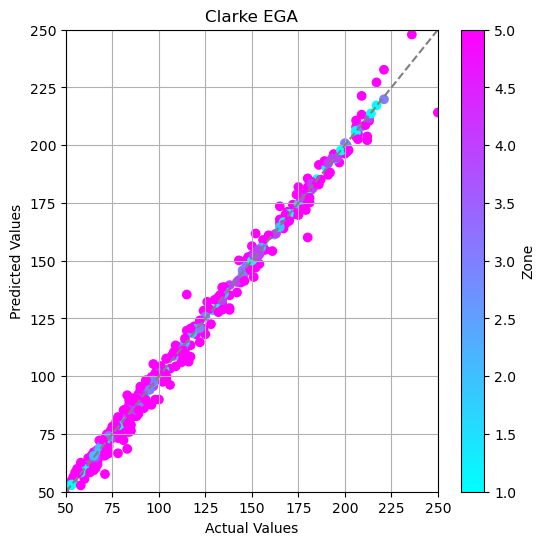

In [167]:
import matplotlib.pyplot as plt

# 生成示例数据，实际观测值和预测值
actual_values = true_value
predicted_values = pred_value

# 计算Clarke EGA图中的区域
def clarke_ega_region(actual, predicted):
    abs_diff = np.abs(predicted - actual)
    zones = np.zeros_like(abs_diff, dtype=int)
    zones[(abs_diff <= 0.4)] = 1
    zones[(abs_diff <= 0.8) & (abs_diff >0.4)] = 2
    zones[(abs_diff <= 1.2) & (abs_diff > 0.8)] = 3
    zones[(abs_diff <= 1.6) & (abs_diff > 1.2)] = 4
    zones[(abs_diff > 1.6)] = 5
    return zones

zones = clarke_ega_region(actual_values, predicted_values)

# 绘制Clarke EGA图
plt.figure(figsize=(6, 6))
plt.scatter(actual_values, predicted_values, c=zones, cmap='cool', marker='o')
plt.plot([50,250], [50, 250], color='gray', linestyle='--')
plt.xlim(50,250)
plt.ylim(50,250)
plt.title("Clarke EGA")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.grid()
plt.colorbar(label="Zone")


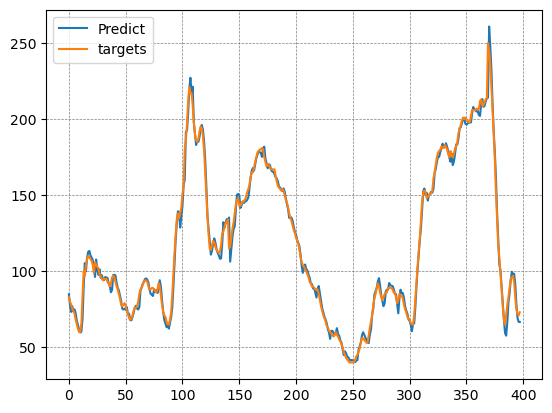

In [339]:
# 绘制predict 和 targets 的对比图
import matplotlib.pyplot as plt

plt.plot(pred_value, label="Predict")    # 预测值
plt.plot(true_value, label="targets")    # 真实值
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [41]:
# 统计一下训练数据的前10000个窗口在模型上的损失值
y_train_pred = model(trainX[:10000,:,:].cuda())
print(y_train_pred.shape)
print(trainY[:10000].shape)
loss_fn(y_train_pred.squeeze(-1).cpu().detach(), trainY[:10000]).item()

torch.Size([10000, 7])
torch.Size([10000, 7])


0.3717721104621887

In [148]:
# 想使用训练集的最后一个窗口预测训练集的下一个数据，再将窗口第一个数据弹出，将预测值插入窗口末尾组成一个新窗口。但是模型的输出是单个血糖值
# 缺了一些时间特征。要想实现真正的预测（有误差积累的预测）必须改变模型，使模型输出一个样本。
result = []
x = testX[0,0,:,:].unsqueeze(0).cuda()
print(x.shape)
for i in range(50):
    y = model(x)

    x = torch.cat((x[:,1:,:], y.unsqueeze(1)), dim=1)
    
    result.append(y.view(-1)[-1].cpu().detach().numpy())

torch.Size([1, 24, 7])


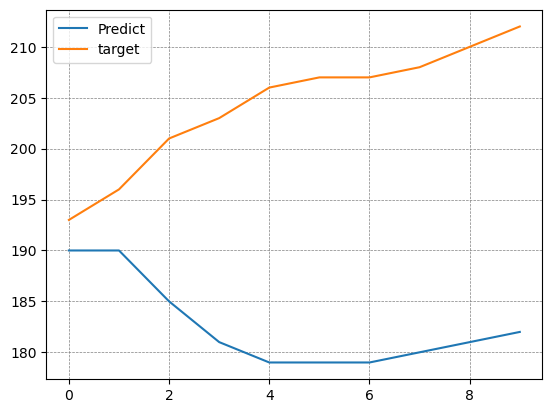

In [149]:
result = np.array(result)
pred_values = scaler.inverse_transform(result.reshape(-1, 1)).round()[:10]

true_values = testY[0,:50,-1].detach().numpy().flatten()
true_values = scaler.inverse_transform(true_values.reshape(-1,1)).round()[:10]

plt.plot(pred_values, label="Predict")
plt.plot(true_values, label='target')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

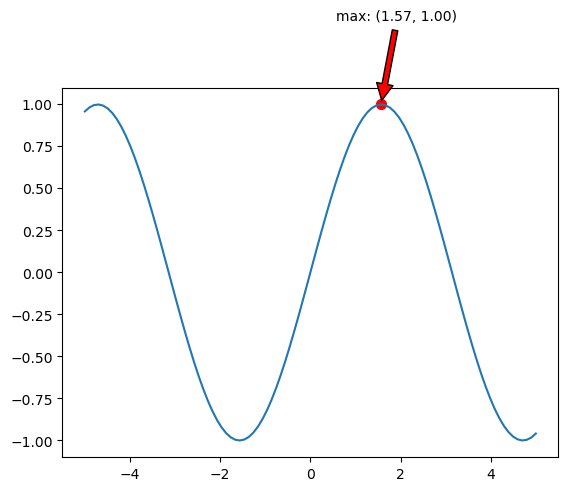

In [17]:
# 绘制预测值与标签的对比图并将低血糖时刻与高血糖时刻在图中标出来

import numpy as np
import matplotlib.pyplot as plt
 
# 生成数据，这里生成一个正弦曲线
x = np.linspace(-5, 5, 100)  # 在[-5,5]之间生成100个点作为x坐标
y = np.sin(x)               # 计算每个x点上的正弦值
 
# 找到最大值点，这里使用np.argmax函数查找y数组中的最大值的索引
max_idx = np.argmax(y)
max_x, max_y = x[max_idx], y[max_idx]
 
# 绘制图形
plt.plot(x, y)              # 绘制正弦曲线
plt.scatter(max_x, max_y, color='red', s=50)  # 在最大值点上绘制一个红色的圆点
plt.annotate(f'max: ({max_x:.2f}, {max_y:.2f})', xy=(max_x, max_y), xytext=(max_x-1, max_y+0.5),
             arrowprops=dict(facecolor='red', shrink=0.05))  # 添加注释，使用红色箭头连接注释和最大值点
plt.show()  